# Lens model parameters recovery

Assess recovery of true lens model parameters when other are kept fixed at their true value.

In [1]:
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.io.fits as pf
import pysap
import tqdm
import corner
import pickle as pkl

from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import class_creator
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from lenstronomy.Plots import chain_plot
from lenstronomy.Util import kernel_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util

from slitronomy.Util.plot_util import nice_colorbar, log_cmap

from TDLMCpipeline.Modelling.mask import ImageMask

np.random.seed(118)

n_points = 40
subgrid_res_source = 2
use_likelihood_mask = False
include_regridding_error = True

%matplotlib inline

In [2]:
def noise_with_SNR(snr_db, image):
    if np.isinf(snr_db):
        return 0, 0
    sigma = np.linalg.norm(image.flatten(), 2) / snr_db
    noise = sigma * np.random.randn(*image.shape)
    return sigma, noise

In [3]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

In [4]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 15

(15, 15)


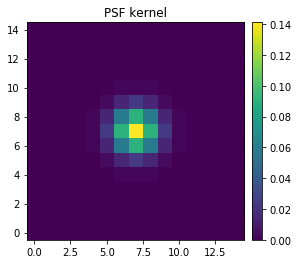

In [5]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class_tmp = ImageData(**kwargs_data)

# PSF specification
psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
print(psf_kernel.shape)
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower')
nice_colorbar(im)
plt.show()

In [6]:
lens_model_list = ['SPEMD', 'SHEAR_GAMMA_PSI']
kwargs_spemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_shear = {'gamma_ext': 0.02, 'psi_ext': 0.5, 'ra_0': kwargs_spemd['center_x'], 'dec_0': kwargs_spemd['center_y']}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles from Galsim (COSMOS galaxy)
galsim_index = 1
snr_data = 500
galsim_data_path = ('../notebooks/data/ring_sims/sims_SNR{}/simring_galsim{}_all.pkl'.format(snr_data, galsim_index))
[data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
galsim_source_highres = truth['source_galsim_3']
background_rms = 0  # we'll the noise afterwards
galsim_num_pix = data['num_pix']
galsim_delta_pix = data['delta_pix']
source_model_list = ['INTERPOL']
kwargs_interpol_source = {'image': galsim_source_highres, 
                          'amp': 3000, 'center_x': +0.3, 'center_y': -0.1, 'phi_G': 0, 
                          'scale': galsim_delta_pix/3}
kwargs_source = [kwargs_interpol_source]
source_model_class = LightModel(light_model_list=source_model_list)

kwargs_truth = {
    'kwargs_lens': kwargs_lens, 
    'kwargs_source': kwargs_source, 
    'kwargs_special': {'delta_x_source_grid': 0, 'delta_y_source_grid': 0},
}

In [7]:
kwargs_numerics_sim = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class_tmp, psf_class, lens_model_class, source_model_class,
                        kwargs_numerics=kwargs_numerics_sim)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source)

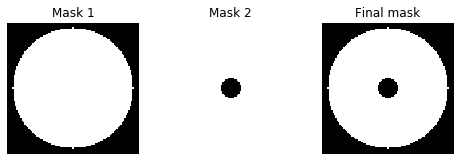

In [8]:
if use_likelihood_mask:
    # prepare mask
    mask_kwargs = {
        'mask_type': 'circle',
        'radius_list': [3.6] + [0.6], 
        'center_list': [None] + [None],
        'inverted_list': [False] + [True], 
        'operation_list': ['inter'],
    }
    imgMask = ImageMask(mask_shape=imageModel.Data.data.shape,
                        delta_pix=imageModel.Data.pixel_width,
                        **mask_kwargs)
    likelihood_mask = imgMask.get_mask(show_details=True)
    likelihood_mask_plot = likelihood_mask
else:
    likelihood_mask = None
    likelihood_mask_plot = np.ones_like(imageModel.Data.data)

## Prepare data at different SNR levels

inf 0
100 0.9757818181803887
500 0.19515636363607775


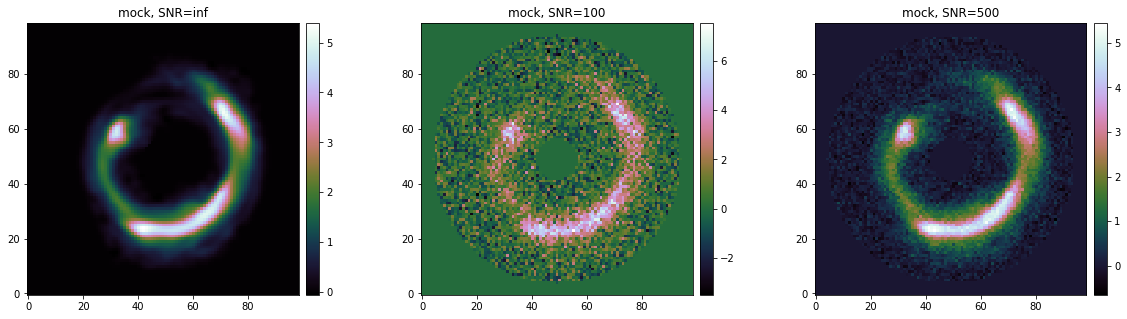

In [9]:
snr_range = [np.inf, 100, 500]
data_class_list = []
for snr in snr_range:
    sigma, noise = noise_with_SNR(snr, image_sim_no_noise)
    print(snr, sigma)
    kwargs_data['image_data'] = image_sim_no_noise + noise
    kwargs_data['background_rms'] = sigma
    kwargs_data['noise_map'] = sigma * np.ones_like(image_sim_no_noise)
    data_class_list.append(ImageData(**kwargs_data))

fig = plt.figure(figsize=(20, 5))
for i, dc in enumerate(data_class_list):
    ax = plt.subplot(1, len(data_class_list), i+1)
    ax.set_title("mock, SNR={}".format(snr_range[i]))
    im = ax.imshow(lin_scale(dc.data)*likelihood_mask_plot, origin='lower', cmap='cubehelix') #, vmin=0)
    nice_colorbar(im)
plt.show()

# remove 'infinite' SNR for the tests
snr_range = snr_range[1:]
data_class_list = data_class_list[1:]

## Prepare solver

In [10]:
source_model_class_sparsefit = LightModel(['STARLETS'])
kwargs_source_sparsefit  = [{'n_scales': 6}]  # starlet coeffs that are optimized for

kwargs_sparse_solver = {
    'source_interpolation': 'bilinear',
    'include_regridding_error': include_regridding_error,
    'subgrid_res_source': subgrid_res_source,
    'sparsity_prior_norm': 1,
    'min_threshold': 3,
    'num_iter_source': 20,
    'num_iter_weights': 3,
    'verbose': False,
    'show_steps': False,
    'thread_count': 8,
}

Negative source pixels ? False (min = 0.00e+00)
Negative image pixels ? True (min = -5.33e-16)


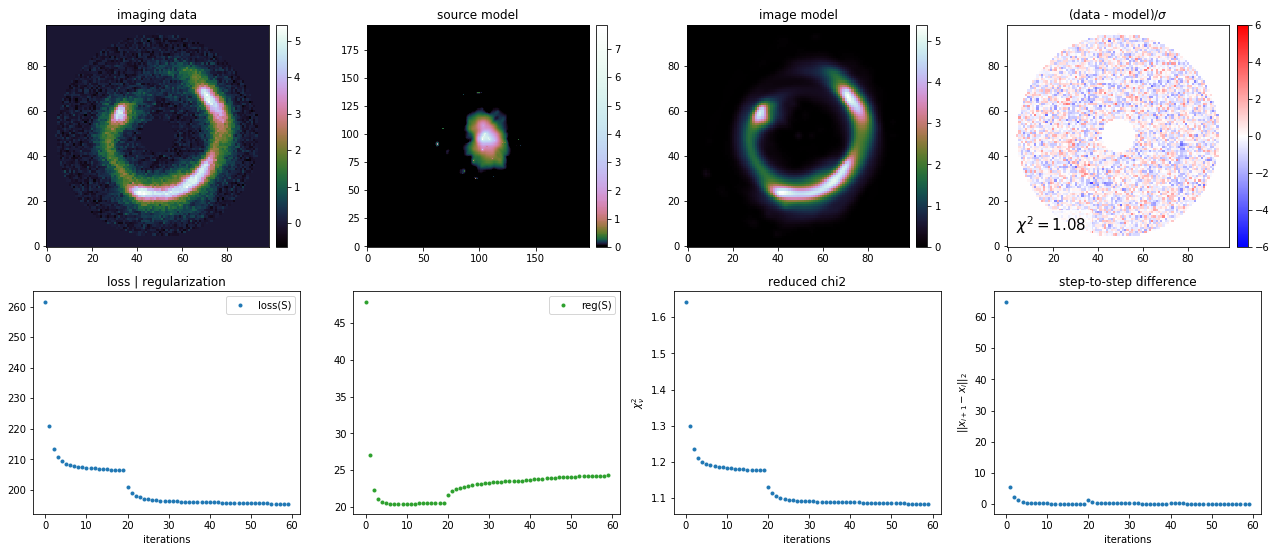

In [11]:
# test on the highest SNR to check for optimal settings
imageSparseFit_test = ImageSparseFit(data_class_list[-1], psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)


_, _, _ = imageSparseFit_test.image_sparse_solve(kwargs_lens=kwargs_truth['kwargs_lens'],
                                                 kwargs_source=kwargs_source_sparsefit)
imageSparseFit_test.sparseSolver.plot_results(cmap_1=log_cmap('cubehelix', 1e-2, 1),
                                              cmap_2='cubehelix')
plt.show()

## One-parameter free tests

In [12]:
def vary_one_parameter(param_name, param_range, kwargs_lens_truth, param_range_zoom=None, n_scales=6):
    fig, axes = plt.subplots(len(snr_range), 3, figsize=(16, 5*len(snr_range)), squeeze=False)
    
    if param_name in ['theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y']:
        idx = lens_model_class.lens_model_list.index('SPEMD')
    elif ['gamma_ext', 'psi_ext', 'ra_0', 'dec_0']:
        idx = lens_model_class.lens_model_list.index('SHEAR_GAMMA_PSI')
    else:
        raise ValueError("Wrong parameter name ?")
    
    # plot true value
    true_value = kwargs_lens_truth[idx][param_name]
    
    def iter_param(param_rge, imsim):
        """iterate over parameter values for a given range, solving the sparse optimization at each iteration"""
        metrics = {'image_chi2': [], 'loss': [], 'reg': []}
        for param_value in tqdm.tqdm(param_rge):
            kwargs_source_var = [{'n_scales': n_scales}]
            kwargs_lens_var = copy.deepcopy(kwargs_lens_truth)
            kwargs_lens_var[idx][param_name] = param_value
            #print(param_name, param_value, kwargs_lens_var)
            try:
                model_fit, model_fit_error, param_fit \
                    = imsim.image_sparse_solve(kwargs_lens=kwargs_lens_var, 
                                                kwargs_source=kwargs_source_var)
            except Exception as e:
                print(e)
                metrics['image_chi2'].append(np.nan)
                metrics['loss'].append(np.nan)
                metrics['reg'].append(np.nan)
            else:
                S = imsim.sparseSolver.source_model
                metrics['image_chi2'].append(imsim.sparseSolver.best_fit_reduced_chi2)
                metrics['loss'].append(imsim.sparseSolver.loss(S=S))
                metrics['reg'].append(imsim.sparseSolver.regularization(S=S))
        return metrics
    
    # iterate over SNRs and parameter values
    for i, snr in enumerate(snr_range):
        axes[i, 0].set_title("varying : '{}' | SNR : {}".format(param_name, snr))
        axes[i, 0].set_xlabel("{}".format(param_name))
        axes[i, 0].set_ylabel("$\chi^2$")
        axes[i, 1].set_ylabel("loss")
        axes[i, 1].set_xlabel("{}".format(param_name))
        axes[i, 2].set_ylabel("regularization")
        axes[i, 2].set_xlabel("{}".format(param_name))
        
        im_sim = ImageSparseFit(data_class_list[i], psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=LightModel(['STARLETS']),
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver)
        
        # iterate over the parameter range
        summary = iter_param(param_range, im_sim)
        
        # plots
        axes[i, 0].plot(param_range, summary['image_chi2'], linestyle='-')
        axes[i, 0].axvline(true_value, linestyle='--', color='black')
        axes[i, 1].plot(param_range, summary['loss'], linestyle='-')
        axes[i, 1].axvline(true_value, linestyle='--', color='black')
        axes[i, 2].plot(param_range, summary['reg'], linestyle='-')
        axes[i, 2].axvline(true_value, linestyle='--', color='black')
        #axes[i, 2].legend()
        
        if param_range_zoom is not None:
            # create zoom panels
            inset0 = inset_axes(axes[i, 0], width='40%', height='30%', loc='upper right')
            inset1 = inset_axes(axes[i, 1], width='40%', height='30%', loc='upper right')
            inset2 = inset_axes(axes[i, 2], width='40%', height='30%', loc='upper right')
            # iterate over the parameter range
            summary_zoom = iter_param(param_range_zoom, im_sim)
            # plots
            inset0.plot(param_range_zoom, summary_zoom['image_chi2'], linestyle='-')
            inset0.axvline(true_value, linestyle='--', color='black', linewidth=1)
            inset1.plot(param_range_zoom, summary_zoom['loss'], linestyle='-')
            inset1.axvline(true_value, linestyle='--', color='black', linewidth=1)
            inset2.plot(param_range_zoom, summary_zoom['reg'], linestyle='-')
            inset2.axvline(true_value, linestyle='--', color='black', linewidth=1)
        else:
            summary_zoom = None
        
    return fig, summary, summary_zoom


### Vary projected mass slope

100%|██████████| 40/40 [00:46<00:00,  1.17s/it]


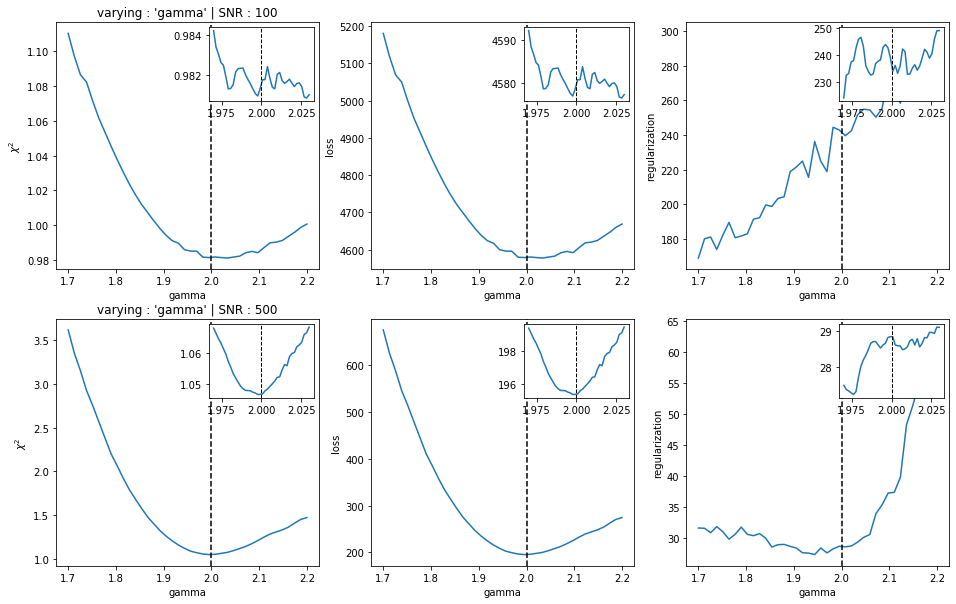

In [13]:
truth = kwargs_truth['kwargs_lens'][0]['gamma']
fig, _, _ = vary_one_parameter('gamma', np.linspace(1.7, 2.2, n_points), kwargs_truth['kwargs_lens'],
                               param_range_zoom=np.linspace(truth-0.03, truth+0.03, n_points))
plt.show()

### Vary Einstein radius

100%|██████████| 40/40 [00:46<00:00,  1.16s/it]


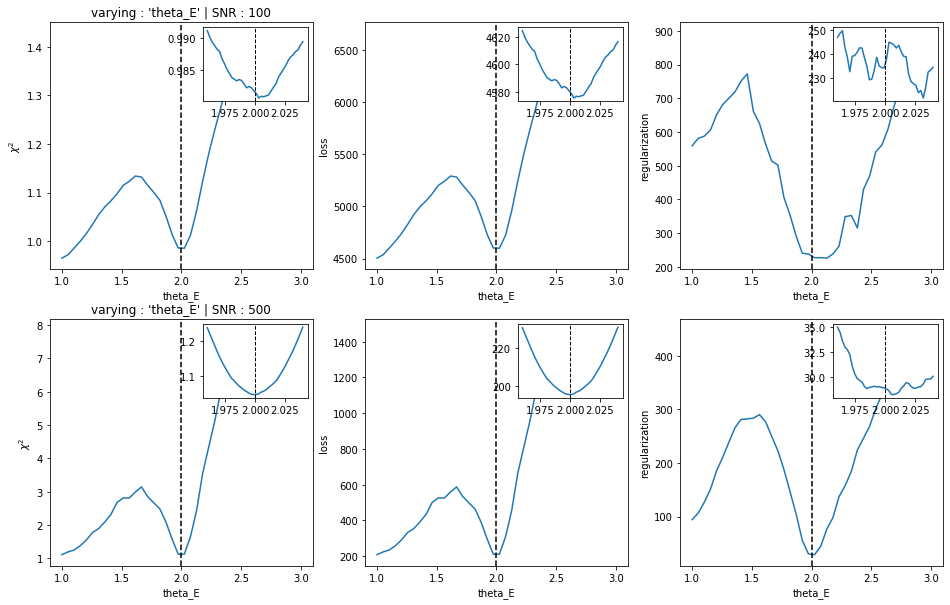

In [14]:
truth = kwargs_truth['kwargs_lens'][0]['theta_E']
fig, _, _ = vary_one_parameter('theta_E', np.linspace(1, 3, n_points), kwargs_truth['kwargs_lens'],
                               param_range_zoom=np.linspace(truth-0.04, truth+0.04, n_points))
plt.show()

### Vary ellipticities

100%|██████████| 40/40 [00:46<00:00,  1.22s/it]


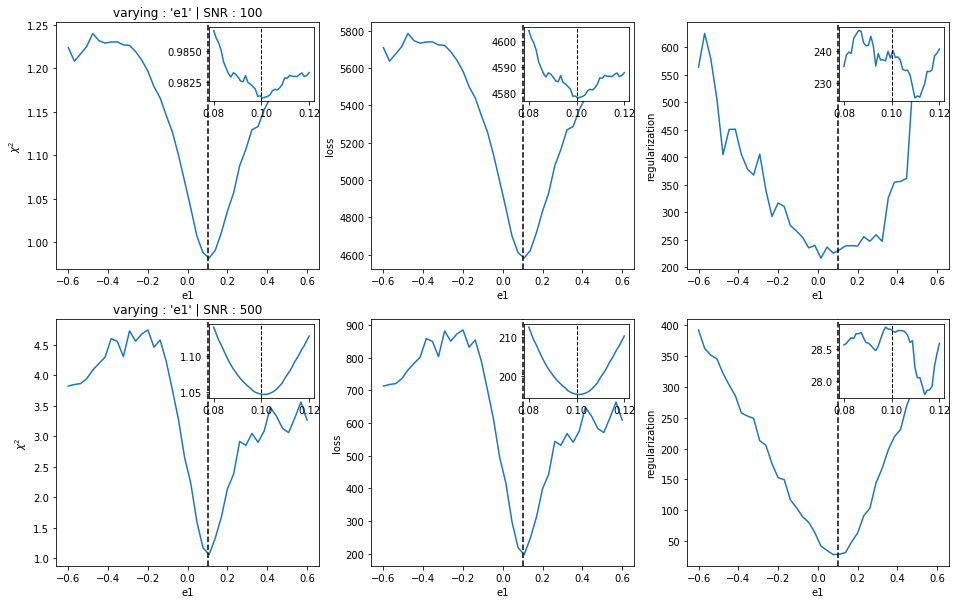

100%|██████████| 40/40 [00:47<00:00,  1.23s/it]


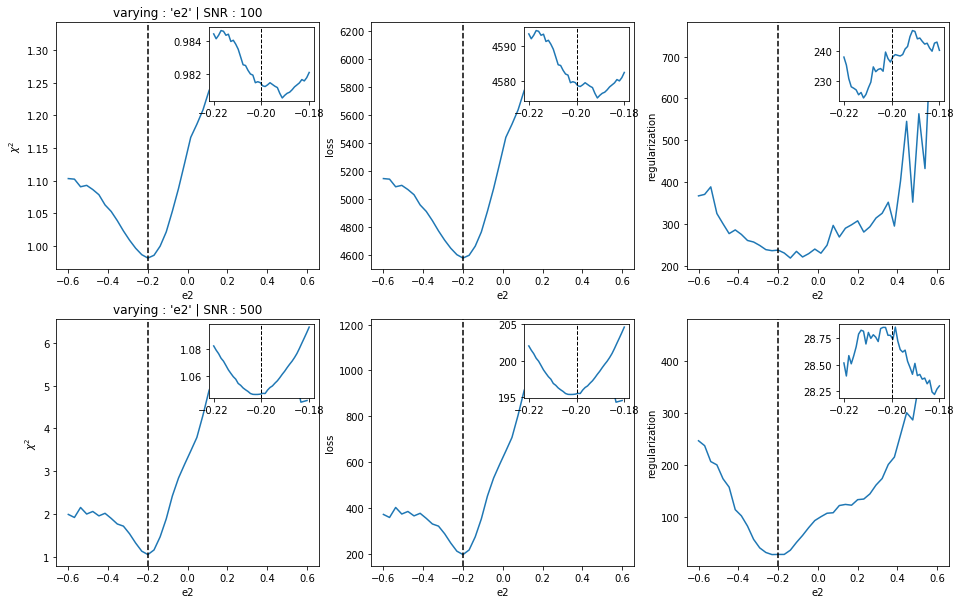

In [15]:
truth = kwargs_truth['kwargs_lens'][0]['e1']
fig, _, _ = vary_one_parameter('e1', np.linspace(-0.6, 0.6, n_points), kwargs_truth['kwargs_lens'],
                               param_range_zoom=np.linspace(truth-0.02, truth+0.02, n_points))
plt.show()
truth = kwargs_truth['kwargs_lens'][0]['e2']
fig, _, _ = vary_one_parameter('e2', np.linspace(-0.6, 0.6, n_points), kwargs_truth['kwargs_lens'],
                               param_range_zoom=np.linspace(truth-0.02, truth+0.02, n_points))
plt.show()

### Vary centroid position

100%|██████████| 40/40 [00:45<00:00,  1.10s/it]


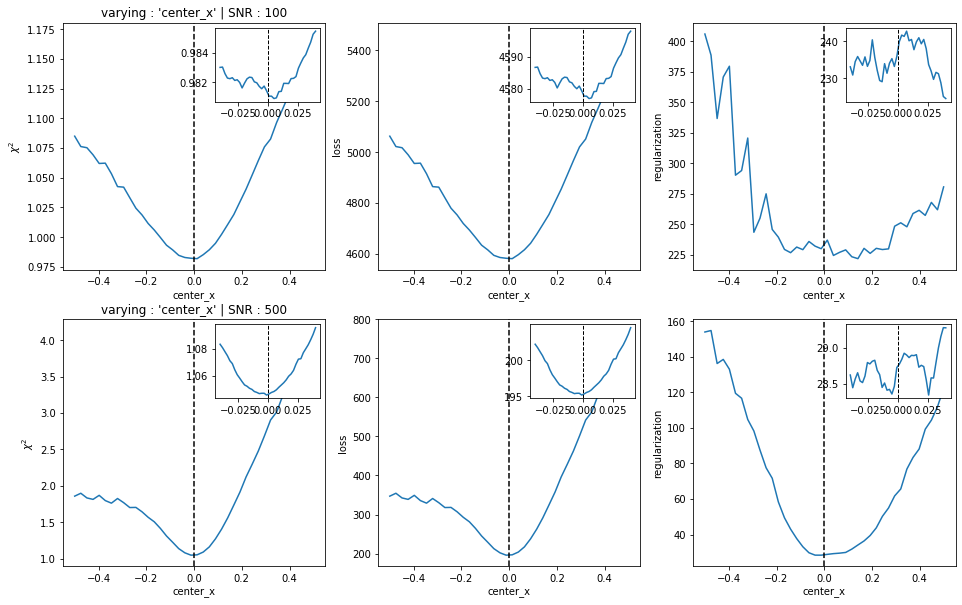

100%|██████████| 40/40 [00:46<00:00,  1.15s/it]


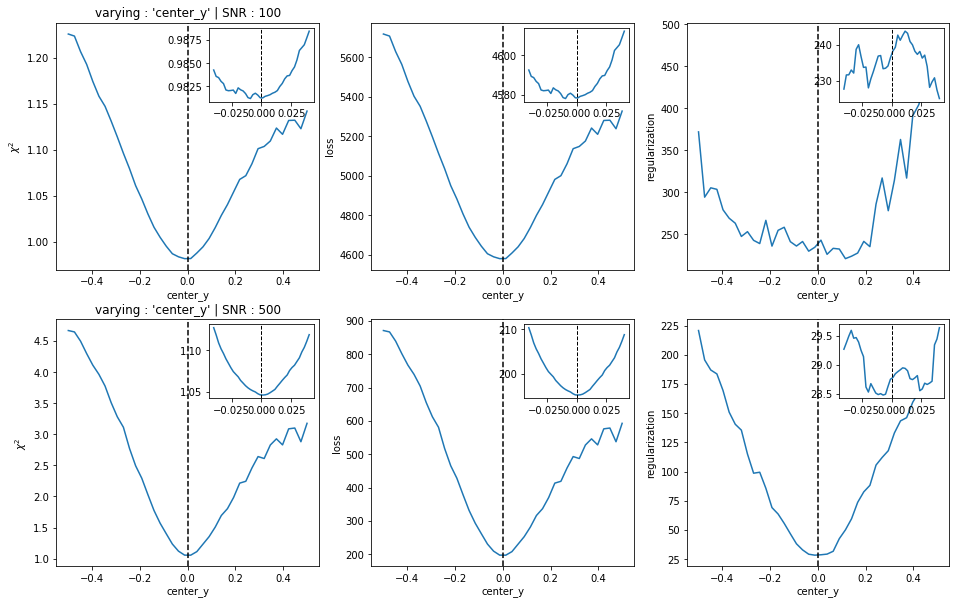

In [16]:
truth = kwargs_truth['kwargs_lens'][0]['center_x']
fig, _, _ = vary_one_parameter('center_x', np.linspace(-0.5, 0.5, n_points), kwargs_truth['kwargs_lens'],
                               param_range_zoom=np.linspace(truth-0.04, truth+0.04, n_points))
plt.show()
truth = kwargs_truth['kwargs_lens'][0]['center_y']
fig, _, _ = vary_one_parameter('center_y', np.linspace(-0.5, 0.5, n_points), kwargs_truth['kwargs_lens'],
                               param_range_zoom=np.linspace(truth-0.04, truth+0.04, n_points))
plt.show()

### Vary external shear

100%|██████████| 40/40 [00:44<00:00,  1.13s/it]


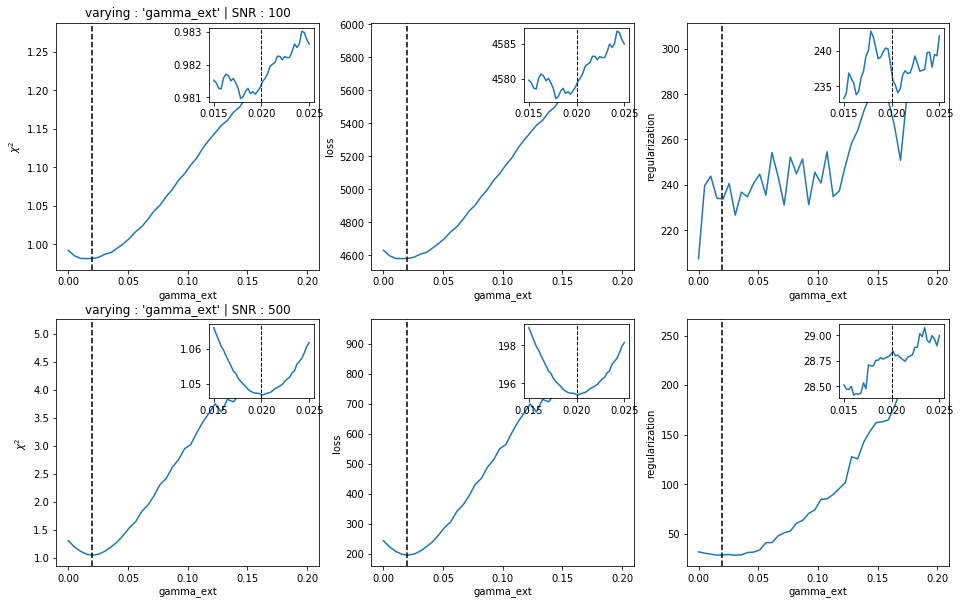

100%|██████████| 40/40 [00:47<00:00,  1.15s/it]


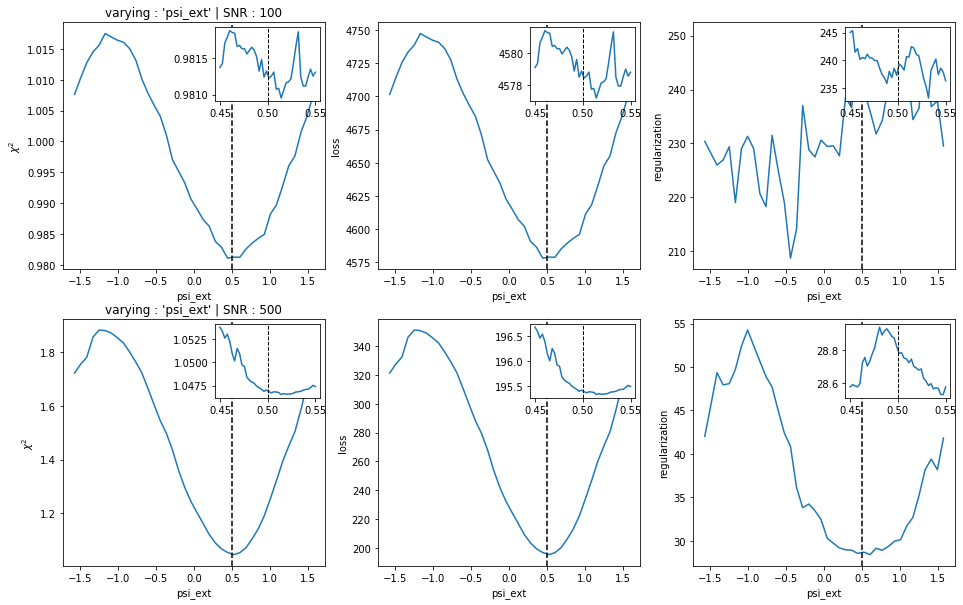

In [17]:
truth = kwargs_truth['kwargs_lens'][1]['gamma_ext']
fig, _, _ = vary_one_parameter('gamma_ext', np.linspace(0, 0.2, n_points), kwargs_truth['kwargs_lens'],
                            param_range_zoom=np.linspace(max(0, truth-0.005), 
                                                         min(1, truth+0.005), n_points))
plt.show()
truth = kwargs_truth['kwargs_lens'][1]['psi_ext']
fig, _, _ = vary_one_parameter('psi_ext', np.linspace(-np.pi/2, np.pi/2, n_points), kwargs_truth['kwargs_lens'],
                            param_range_zoom=np.linspace(truth-0.05, truth+0.05, n_points))
plt.show()